In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Load Data: ESM2M

## Capacity Data

In [2]:
# Load ESM2M labor capacity data
ds_esm2m = xr.open_mfdataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens*_1950-2100.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})
ds_esm2m = ds_esm2m.rename({'__xarray_dataarray_variable__':'capacity'})

In [3]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_esm2m = lf.calc_baseline(ds_esm2m).compute()

[########################################] | 100% Completed | 45.9s


In [4]:
# Shorten capacity dataset to 2000-2100
ds_esm2m = ds_esm2m.sel(time=slice('2000-01-31',None))['capacity']

## Population/Land Area Data

In [2]:
# Population data
ds_pop_esm2m = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m.nc')['population']
ds_pop_esm2m = ds_pop_esm2m.where(np.isfinite(ds_pop_esm2m),0)
ds_pop_esm2m = ds_pop_esm2m.rename({'latitude':'lat','longitude':'lon'})

# Load area data
land_area_esm2m = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_mask = np.isfinite(land_area_esm2m)
# Replace NaN with 0 
land_area_esm2m = land_area_esm2m.where(land_mask,0)

## Load ToEs

In [3]:
ds_toe_esm2m = xr.open_dataset('../data/processed/GFDL/emergence_times.nc')

## Calculate ToEs

In [6]:
# Labor reduction thresholds used to define ToE
labor_thres = [0.9,0.8,0.7]

# Calculate ToEs for all grid cells and ensemble members
with ProgressBar():
    ds_toe_esm2m = lf.toe_summer(ds_esm2m,ds_base_esm2m,labor_thres).compute()

[########################################] | 100% Completed |  3min  5.3s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  4.3s


# Load Data: CESM2

## Capacity Data

In [4]:
# Load ESM2M labor capacity data
ds_cesm2 = xr.open_mfdataset('../data/processed/CESM2/Monthly_Capacity/*',combine='nested',concat_dim='ensemble',chunks={'time':1000}).rename({'__xarray_dataarray_variable__':'capacity'})

In [5]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_cesm2 = lf.calc_baseline(ds_cesm2).compute()

[########################################] | 100% Completed |  1min 12.9s


In [6]:
# Shorten capacity dataset to 2000-2100
ds_cesm2 = ds_cesm2.sel(time=slice('2000-01-31',None))['capacity']

## Population/Land Data

In [4]:
# Population data
ds_pop_cesm2 = xr.open_dataset('../data/processed/CESM2/population_regrid_cesm2.nc')['population']
ds_pop_cesm2 = ds_pop_cesm2.where(np.isfinite(ds_pop_cesm2),0)
ds_pop_cesm2 = ds_pop_cesm2.rename({'latitude':'lat','longitude':'lon'})

# Load area data
land_area_cesm2 = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__']
land_mask = np.isfinite(land_area_cesm2)
# Replace NaN with 0 
land_area_cesm2 = land_area_cesm2.where(land_mask,0).isel(ensemble=0)

## Load ToEs

In [5]:
ds_toe_cesm2 = xr.open_dataset('../data/processed/CESM2/ToEs/emergence_times_ens1-15.nc')

## Calculate ToEs

In [8]:
# Labor reduction thresholds and frequency threshold (# reduced months per year) used to define ToE
labor_thres = [0.9,0.8,0.7]

with ProgressBar():
    # Calculate ToEs for all grid cells and ensemble members
    ds_toe_cesm2 = lf.toe_summer(ds_cesm2,ds_base_cesm2,labor_thres).compute()

[########################################] | 100% Completed |  5min 40.7s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.1s


# ToE Plots

## Spatial Maps

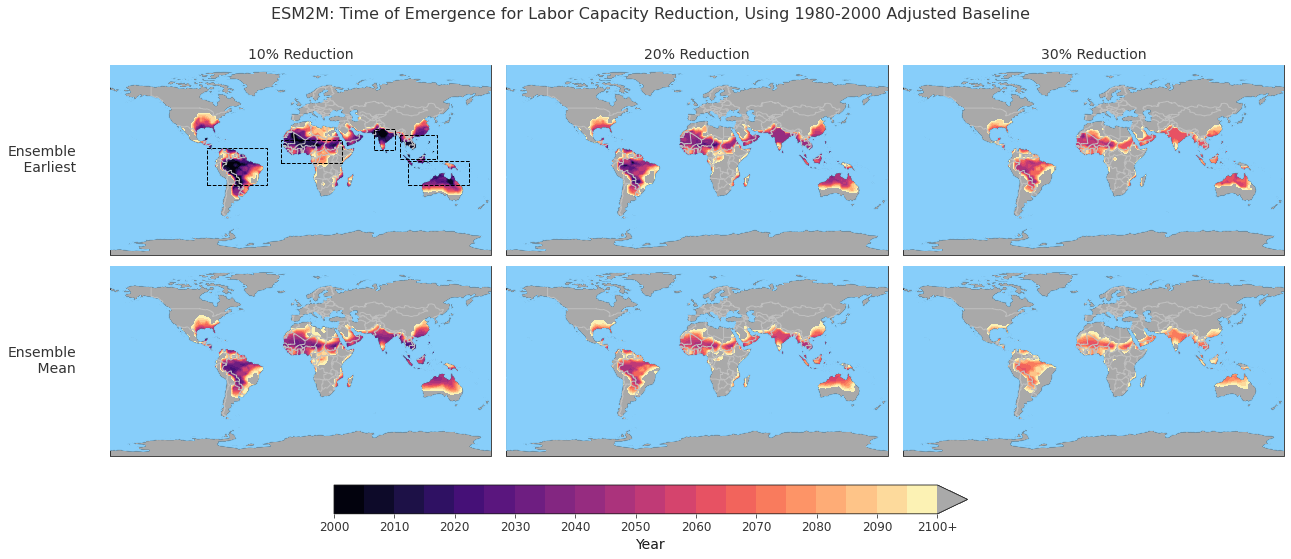

In [7]:
lf.spatial_toe(ds_toe_esm2m,'ESM2M: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline')

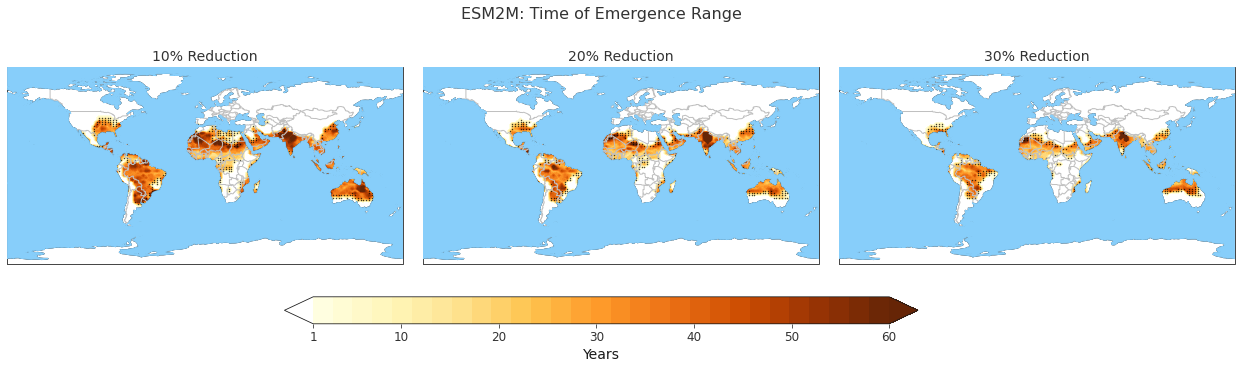

In [16]:
lf.spatial_toe_diff(ds_toe_esm2m,'ESM2M: Time of Emergence Range',s=0.5)

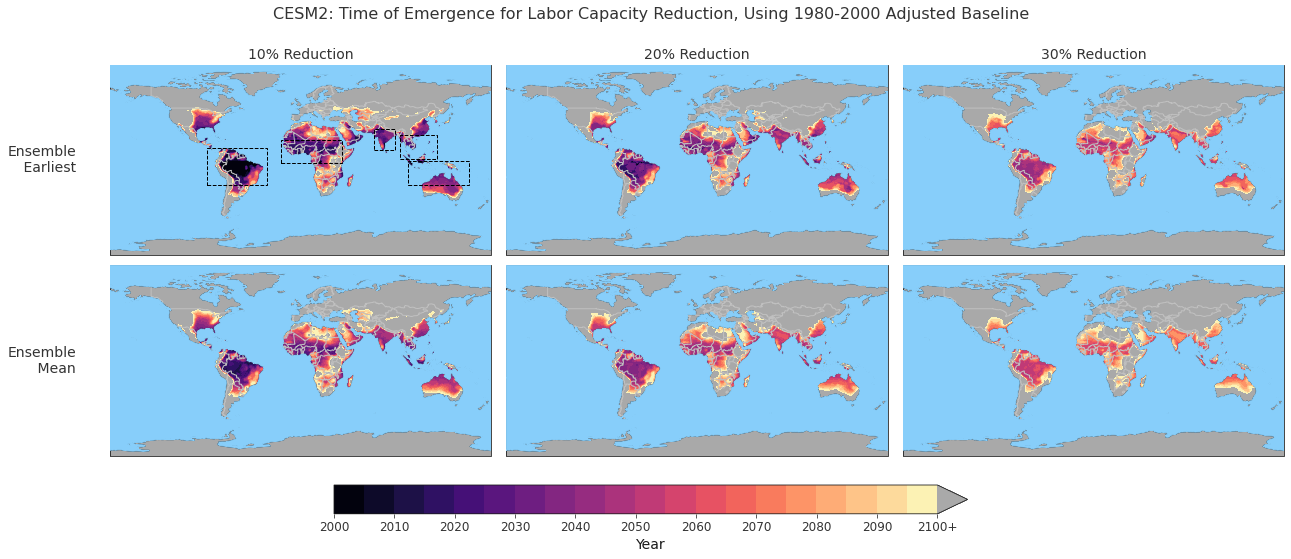

In [55]:
lf.spatial_toe(ds_toe_cesm2,'CESM2: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline')

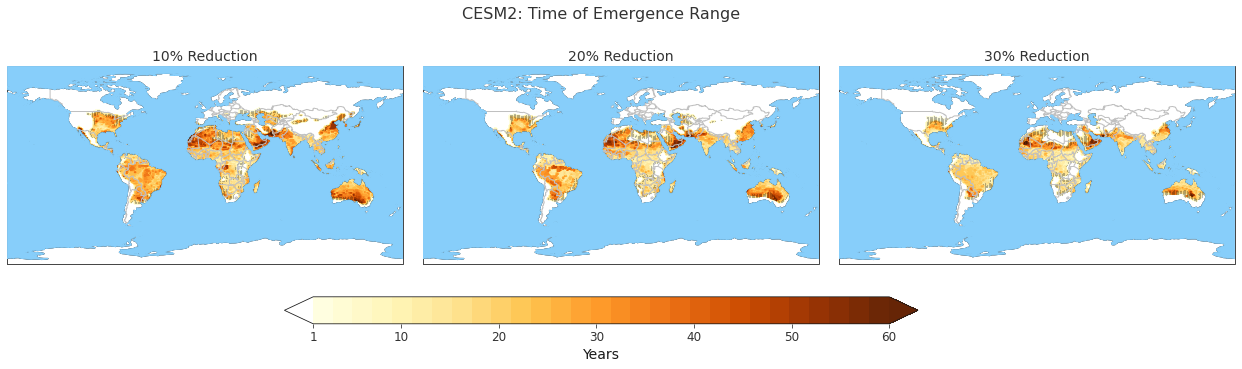

In [59]:
lf.spatial_toe_diff(ds_toe_cesm2,'CESM2: Time of Emergence Range',s=0.035)

# Event Plot

In [64]:
regions = ['India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']

esm2m_90 = xr.Dataset()
esm2m_80 = xr.Dataset()
esm2m_70 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    esm2m_90[region] = ds_region['0.9'].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_80[region] = ds_region['0.8'].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_70[region] = ds_region['0.7'].weighted(ds_pop_esm2m).mean(['lat','lon'])

esm2m_90 = esm2m_90.to_array(dim='region')
esm2m_80 = esm2m_80.to_array(dim='region')
esm2m_70 = esm2m_70.to_array(dim='region')

In [65]:
cesm2_90 = xr.Dataset()
cesm2_80 = xr.Dataset()
cesm2_70 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    cesm2_90[region] = ds_region['0.9'].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_80[region] = ds_region['0.8'].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_70[region] = ds_region['0.7'].weighted(ds_pop_cesm2).mean(['lat','lon'])
    
cesm2_90 = cesm2_90.to_array(dim='region')
cesm2_80 = cesm2_80.to_array(dim='region')
cesm2_70 = cesm2_70.to_array(dim='region')

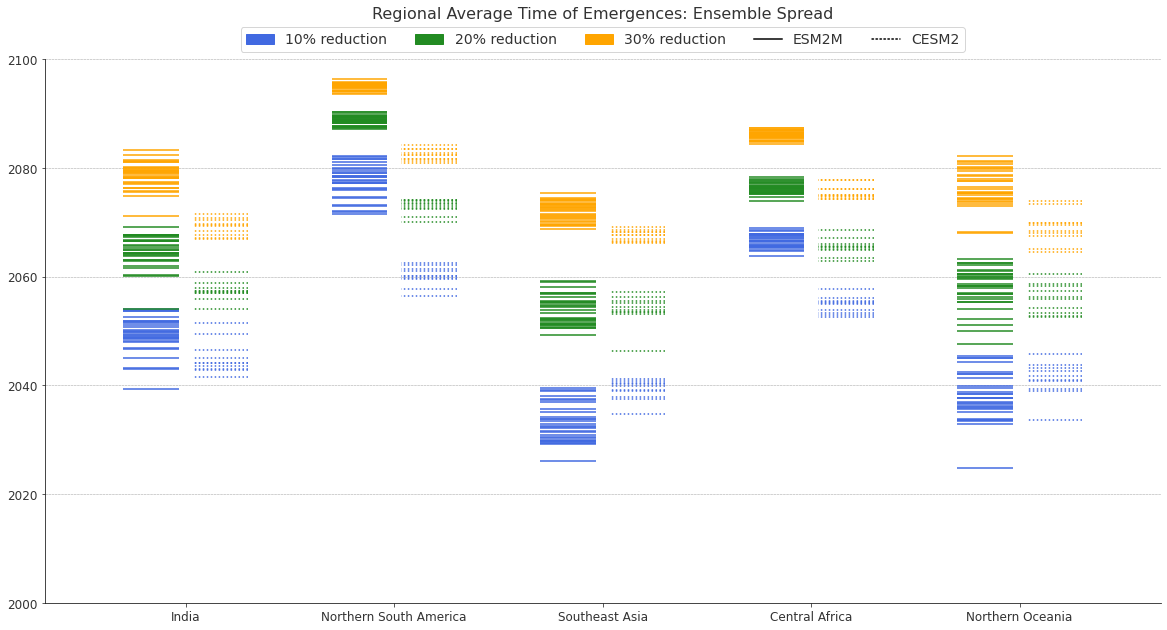

In [67]:
fig,ax=plt.subplots(figsize=(20,10))
ax.eventplot(esm2m_90,orientation='vertical',colors='royalblue',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_80,orientation='vertical',colors='forestgreen',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_70,orientation='vertical',colors='orange',linelengths=0.8,lineoffsets=[1,4,7,10,13]);

ax.eventplot(cesm2_90,orientation='vertical',colors='royalblue',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_80,orientation='vertical',colors='forestgreen',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_70,orientation='vertical',colors='orange',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);

locs = np.arange(1.5,16.5,3)
ax.set_xticks(locs)
ax.set_xticklabels(regions);
ax.set_ylim([2000,2100]);
ax.set_title('Regional Average Time of Emergences: Ensemble Spread\n\n',fontsize=16);

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='CESM2')

ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));

# Box Plot

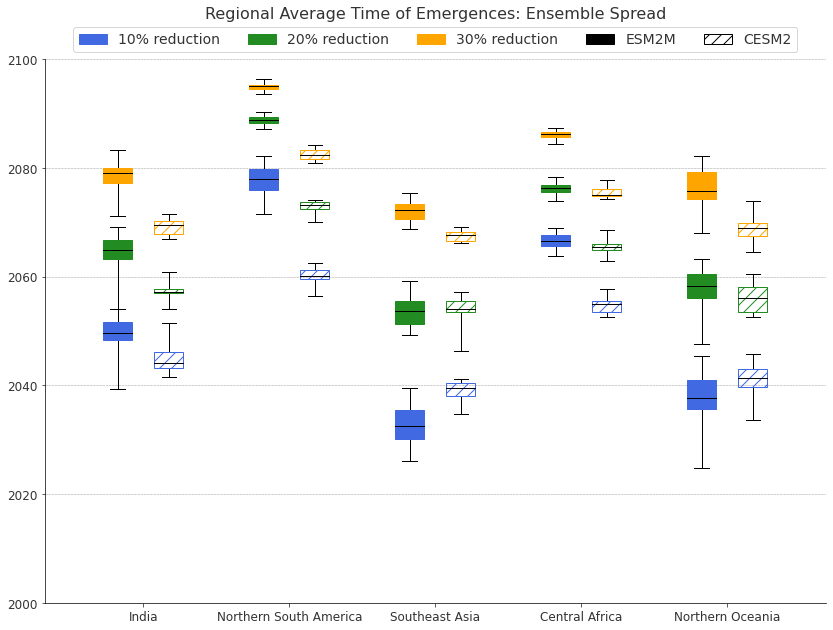

In [68]:
fig,ax=plt.subplots(figsize=(14,10))

blue = dict(facecolor='royalblue',edgecolor='royalblue')
green = dict(facecolor='forestgreen',edgecolor='forestgreen')
orange = dict(facecolor='orange',edgecolor='orange')

blue_hatch = dict(fill=False,hatch='//',color='royalblue')
green_hatch = dict(fill=False,hatch='//',color='forestgreen')
orange_hatch = dict(fill=False,hatch='//',color='orange')

black = dict(color='black')
             
ax.boxplot(esm2m_90,whis=5,boxprops=blue,medianprops=black,showfliers=False,positions=[1,2,3,4,5],widths=0.2,patch_artist=True);
ax.boxplot(esm2m_80,whis=5,boxprops=green,medianprops=black,showfliers=False,positions=[1,2,3,4,5],widths=0.2,patch_artist=True);
ax.boxplot(esm2m_70,whis=5,boxprops=orange,medianprops=black,showfliers=False,positions=[1,2,3,4,5],widths=0.2,patch_artist=True);

ax.boxplot(cesm2_90,whis=5,boxprops=blue_hatch,medianprops=black,showfliers=False,positions=[1.35,2.35,3.35,4.35,5.35],widths=0.2,patch_artist=True);
ax.boxplot(cesm2_80,whis=5,boxprops=green_hatch,medianprops=black,showfliers=False,positions=[1.35,2.35,3.35,4.35,5.35],widths=0.2,patch_artist=True);
ax.boxplot(cesm2_70,whis=5,boxprops=orange_hatch,medianprops=black,showfliers=False,positions=[1.35,2.35,3.35,4.35,5.35],widths=0.2,patch_artist=True);

locs = np.arange(1.175,6.175,1)
ax.set_xticks(locs)
ax.set_xticklabels(regions);
ax.set_ylim([2000,2100]);
ax.set_title('Regional Average Time of Emergences: Ensemble Spread\n\n',fontsize=16);

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')

solid_patch = mpatches.Patch(color='black', label='ESM2M')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2')
ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_patch,hatch_patch],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));

# Bar Chart

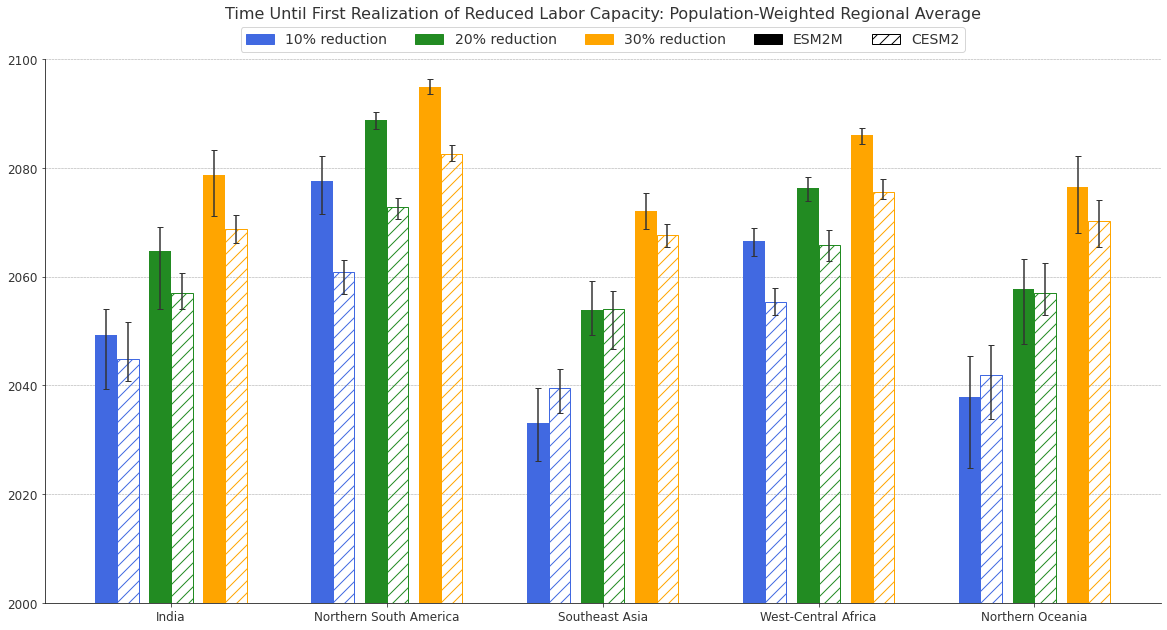

In [8]:
# Regions to plot
regions = ['India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']

# Location of region labels; width of bars
locs = np.arange(len(regions))
width = 0.1

fig, ax = plt.subplots(figsize=(20,10))

for x in locs:
    region = regions[x]
    # Get ToEs for grid cells in region
    ds_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    ds_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')

    # Population-weighted average ToE
    esm2m_avg = ds_esm2m.weighted(ds_pop_esm2m).mean(['lon','lat'])
    cesm2_avg = ds_cesm2.weighted(ds_pop_cesm2).mean(['lon','lat'])

    # [[Lower range],[upper range]] -- range of values across ensemble members
    errors_esm2m_above = esm2m_avg.max('ensemble')-esm2m_avg.mean('ensemble')
    errors_esm2m_below = esm2m_avg.mean('ensemble')-esm2m_avg.min('ensemble')

    errors_cesm2_above = cesm2_avg.max('ensemble')-cesm2_avg.mean('ensemble')
    errors_cesm2_below = cesm2_avg.mean('ensemble')-cesm2_avg.min('ensemble')
    
    ec = (0.2,0.2,0.2)
    
    ax.bar(x-3*width,esm2m_avg['0.9'].mean('ensemble'),width,yerr=[[errors_esm2m_below['0.9']],[errors_esm2m_above['0.9']]],color='royalblue',ecolor=ec)
    ax.bar(x-2*width,cesm2_avg['0.9'].mean('ensemble'),width,yerr=[[errors_cesm2_below['0.9']],[errors_cesm2_above['0.9']]],edgecolor='royalblue',fill=False,hatch='//',ecolor=ec)
    
    ax.bar(x-0.5*width,esm2m_avg['0.8'].mean('ensemble'),width,yerr=[[errors_esm2m_below['0.8']],[errors_esm2m_above['0.8']]],color='forestgreen',ecolor=ec)
    ax.bar(x+0.5*width,cesm2_avg['0.8'].mean('ensemble'),width,yerr=[[errors_cesm2_below['0.8']],[errors_cesm2_above['0.8']]],edgecolor='forestgreen',fill=False,hatch='//',ecolor=ec)
    
    ax.bar(x+2*width,esm2m_avg['0.7'].mean('ensemble'),width,yerr=[[errors_esm2m_below['0.7']],[errors_esm2m_above['0.7']]],color='orange',ecolor=ec)
    ax.bar(x+3*width,cesm2_avg['0.7'].mean('ensemble'),width,yerr=[[errors_cesm2_below['0.7']],[errors_cesm2_above['0.7']]],edgecolor='orange',fill=False,hatch='//',ecolor=ec)

# Region labels on top
ax.set_xticks(locs)
ax.set_xticklabels(regions)
ax.set_ylim([2000,2100]);

# Legend for different thresholds
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')

solid_patch = mpatches.Patch(color='black', label='ESM2M')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2')

ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_patch,hatch_patch],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));

ax.set_title('Time Until First Realization of Reduced Labor Capacity: Population-Weighted Regional Average\n\n',fontsize=16);

# Time Series

In [9]:
def frac_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax):
    # Calculate fraction of area that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m['0.9'].min(dim='ensemble'),ds_frac_esm2m['0.9'].max(dim='ensemble'),alpha=0.15,color='royalblue')
    ds_frac_esm2m['0.9'].mean(dim='ensemble').plot(ax=ax,color='royalblue',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m['0.8'].min(dim='ensemble'),ds_frac_esm2m['0.8'].max(dim='ensemble'),alpha=0.15,color='forestgreen')
    ds_frac_esm2m['0.8'].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m['0.7'].min(dim='ensemble'),ds_frac_esm2m['0.7'].max(dim='ensemble'),alpha=0.15,color='orange')
    ds_frac_esm2m['0.7'].mean(dim='ensemble').plot(ax=ax,color='orange',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2['0.9'].min(dim='ensemble'),ds_frac_cesm2['0.9'].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='royalblue',linewidth=1.5)
    ds_frac_cesm2['0.9'].mean(dim='ensemble').plot(ax=ax,color='royalblue',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2['0.8'].min(dim='ensemble'),ds_frac_cesm2['0.8'].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='forestgreen',linewidth=1.5)
    ds_frac_cesm2['0.8'].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2['0.7'].min(dim='ensemble'),ds_frac_cesm2['0.7'].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='orange',linewidth=1.5)
    ds_frac_cesm2['0.7'].mean(dim='ensemble').plot(ax=ax,color='orange',linestyle='dashed',linewidth=3)
    
    # Set labels, limits
    ax.set_xlabel('Year')
    ax.set_ylabel('Fraction of Population')
    ax.set_ylim([0,1])
    ax.set_xlim([2010,2100])
    ax.set_xticks(np.linspace(2020,2100,5))
    ax.set_title(title)

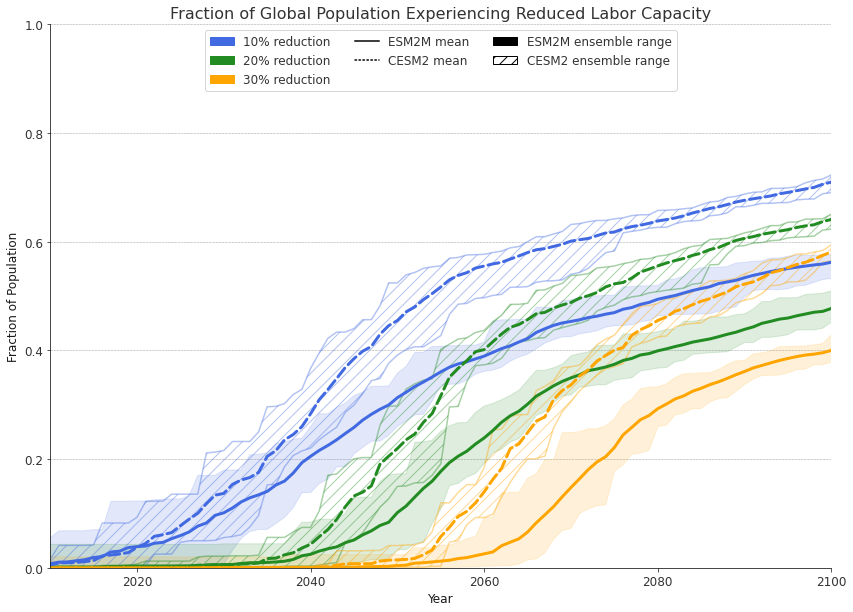

In [133]:
fig,ax=plt.subplots(figsize=(14,10))

frac_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,None,ax)

ax.set_title('Fraction of Global Population Experiencing Reduced Labor Capacity',fontsize=16)

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M mean')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='CESM2 mean')

solid_patch = mpatches.Patch(color='black', label='ESM2M ensemble range')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2 ensemble range')

ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line,solid_patch,hatch_patch],ncol=3,fancybox=True,loc='upper center',fontsize=12);

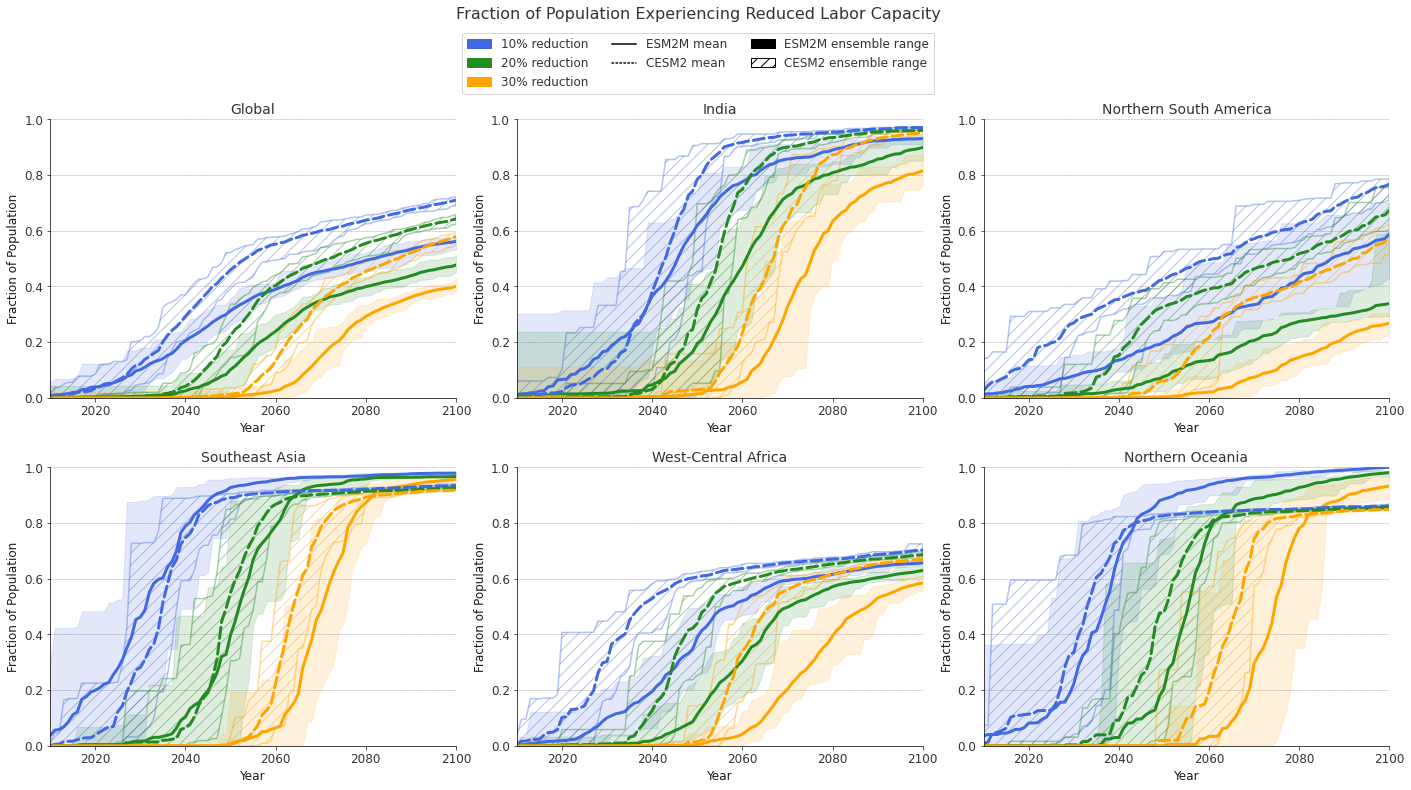

In [10]:
regions = ['Global','India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']

# Create figure and axes
fig, axs = plt.subplots(figsize=(24,12),nrows=2,ncols=3)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/3)][index%3]
    index+=1
    
    ds_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    ds_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    frac_emerge_plot(ds_esm2m,ds_cesm2,pop_esm2m,pop_cesm2,region,ax)

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M mean')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='CESM2 mean')

solid_patch = mpatches.Patch(color='black', label='ESM2M ensemble range')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2 ensemble range')

fig.subplots_adjust(top=0.85)
legend_ax = fig.add_axes([0.3, 0.875, 0.4, 0.08])
legend_ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line,solid_patch,hatch_patch],ncol=3,fancybox=True,loc='center',fontsize=12);
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

fig.subplots_adjust(wspace=.15,hspace=.25)
fig.suptitle('Fraction of Population Experiencing Reduced Labor Capacity',fontsize=16);